# Exercise - denoising

Use the Fashion MNIST data to solve this exercise. Load the images. Then, create a version of the images where artificial noise is added. Your main objective is to remove this noise.

1. Using an autoencoder where the input is the noisy images and the output is the original images, attempt to remove the noise. Note how this is essentially a supervised task.
1. Suppose you only longer have access to original images (i.e. without noise) for training. Train an autoencoder to encode and decode these. Then, use it to encode and decode the *noisy* test images and see if this helps to remove noise. Note how this is an unsupervised task with respect to noise removal.
1. Suppose you no longer have access to original images (i.e. without noise) but only the noisy images for training. Train an autoencoder to encode and decode these. Then, use it to encode and decode the noisy test images and see if this helps to remove noise. Note how this is an unsupervised task with respect to noise removal.

**Hint**: Consider looking at https://www.tensorflow.org/tutorials/generative/autoencoder, as they go through some of the same steps.

**Hint**: See https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose for details on transposed convolutions.

**See slides for more details!**

# Setup

This is simply some code to prepare the data. Mostly similar to https://www.tensorflow.org/tutorials/generative/autoencoder.

In [13]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model

(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

x_train, x_test = x_train / 255, x_test / 255 #normalize by pixel value, so it is between 0 and 1

x_train = x_train.reshape((*x_train.shape, 1)) # * means that you are unpacking the vector
x_test = x_test.reshape((*x_test.shape, 1)) # Unpacked changes the dimensions from ([28,28]1) to [28,28,1]

print(x_train.shape, x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [2]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) # adding 20% noise element by element
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.) # Since adding 20% might get it over 1 it just cuts it to 1 and 0 since we want [0,1]
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

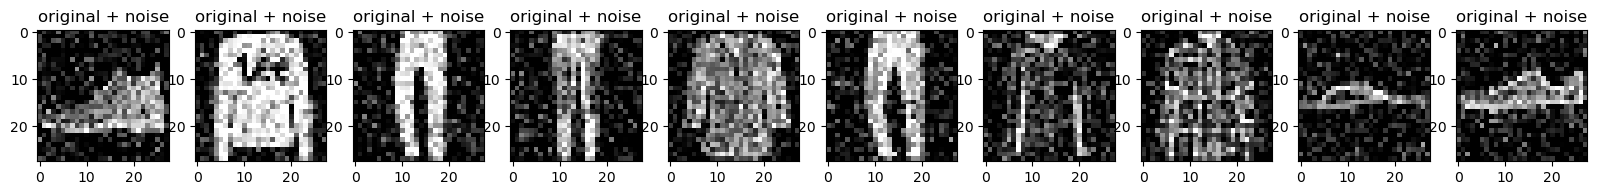

In [3]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

# Exercise 1

Using an autoencoder where the input is the noisy images and the output is the original images, attempt to remove the noise. Note how this is essentially a supervised task.

In [19]:
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', strides=2, input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same', strides=2),
], name='encoder')
decoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2DTranspose(8, 3, strides=2, activation='relu', padding='same', input_shape=(7, 7, 8)), # This shape is known by summarizing thee encoder # specify 1 first
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same'), # activation is sigmoid because output needs to be 0 and 1
], name='decoder')


In [20]:
autoencoder = tf.keras.models.Sequential([encoder, decoder], name='autoencoder')

autoencoder.compile(loss='mse', optimizer='adam') # MSE becasue we are comparig effectively two function original and reconstructed
# build encoder and the get the shape and then the decoder
autoencoder.summary() # Here we see the output shape of the encoder which is then put into the decoder

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 7, 7, 8)           1320      
                                                                 
 decoder (Sequential)        (None, 28, 28, 1)         1897      
                                                                 
Total params: 3,217
Trainable params: 3,217
Non-trainable params: 0
_________________________________________________________________


In [21]:
autoencoder.fit(x_train_noisy, x_train, validation_data=(x_test_noisy, x_test), epochs=10)
# x_train is the labels 

Epoch 1/10
1875/1875 [==============================] - 40s 21ms/step - loss: 0.0170 - val_loss: 0.0092
Epoch 2/10
1875/1875 [==============================] - 38s 20ms/step - loss: 0.0086 - val_loss: 0.0081
Epoch 3/10
1875/1875 [==============================] - 38s 20ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 4/10
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 5/10
1875/1875 [==============================] - 38s 20ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 6/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 7/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 8/10
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 9/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0068 - val_loss: 0.0067
Epoch 10/10
1875/1875 [==============================] - 37s 20m

In [22]:
denoised_images = autoencoder.predict(x_test_noisy)

313/313 [==============================] - 2s 6ms/step


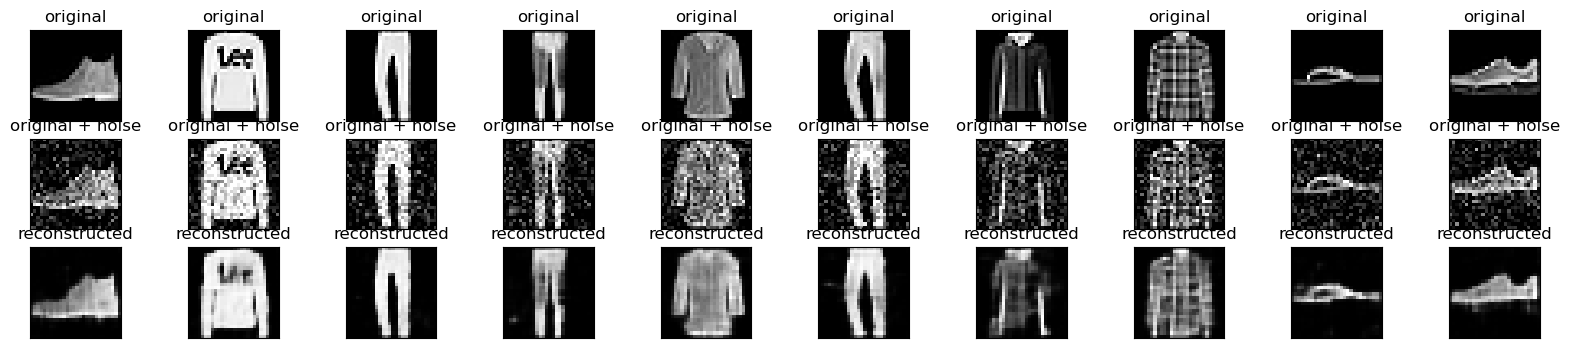

In [24]:
#see denoised images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display original + noise
    ax = plt.subplot(3, n, i + n + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + 2 * n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(denoised_images[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

In [25]:
mse_noisy_original = np.mean(np.square(x_test_noisy - x_test))
mse_reconstructed_original = np.mean(np.square(denoised_images - x_test))

print(f'MSE of noisy images to original images = {mse_noisy_original}.')
print(f'MSE of reconstructed noisy images to original images = {mse_reconstructed_original}.')

MSE of noisy images to original images = 0.025508766993880272.
MSE of reconstructed noisy images to original images = 0.006750476654049501.


# Exercise 2

Suppose you only longer have access to original images (i.e. without noise) for training. Train an autoencoder to encode and decode these. Then, use it to encode and decode the *noisy* test images and see if this helps to remove noise. Note how this is an unsupervised task with respect to noise removal.

Same as before although we only train on noisy image

In [ ]:
encoder = tf.keras.models.Sequential([
    ??
], name='encoder')
decoder = tf.keras.models.Sequential([
    ??
], name='decoder')

In [ ]:
autoencoder = tf.keras.models.Sequential([encoder, decoder], name='autoencoder')

autoencoder.compile(loss='mse', optimizer='adam')

autoencoder.summary()

In [ ]:
autoencoder.fit(x_train, x_train, validation_data=(x_test_noisy, x_test), epochs=10)

In [ ]:
denoised_images = autoencoder.predict(x_test_noisy)

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display original + noise
    ax = plt.subplot(3, n, i + n + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + 2 * n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(denoised_images[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

# Exercise 3

Suppose you no longer have access to original images (i.e. without noise) but only the noisy images for training. Train an autoencoder to encode and decode these. Then, use it to encode and decode the noisy test images and see if this helps to remove noise. Note how this is an unsupervised task with respect to noise removal.

In [ ]:
encoder = tf.keras.models.Sequential([
    ??
], name='encoder')
decoder = tf.keras.models.Sequential([
    ??
], name='decoder')

In [ ]:
autoencoder = tf.keras.models.Sequential([encoder, decoder], name='autoencoder')

autoencoder.compile(loss='mse', optimizer='adam')

autoencoder.summary()

In [ ]:
autoencoder.fit(x_train_noisy, x_train_noisy, validation_data=(x_test_noisy, x_test), epochs=10)

In [ ]:
denoised_images = autoencoder.predict(x_test_noisy)

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display original + noise
    ax = plt.subplot(3, n, i + n + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + 2 * n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(denoised_images[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()